In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from IPython.display import display
from collections import Counter

%matplotlib inline

In [69]:
!pip install tqdm
from tqdm.auto import tqdm

In [2]:
pd

<module 'pandas' from '/home/codespace/.local/lib/python3.12/site-packages/pandas/__init__.py'>

In [3]:
np

<module 'numpy' from '/home/codespace/.local/lib/python3.12/site-packages/numpy/__init__.py'>

In [74]:
df = pd.read_csv('course_lead_scoring_hw_4.csv')

In [75]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [76]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [77]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

In [78]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)
len(df_full_train), len(df_train), len(df_val), len(df_test)

(1169, 876, 293, 293)

In [79]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [80]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [81]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [82]:
for feature in numerical:
    score = df_train[feature]
    score = roc_auc_score(y_train, score)
    print('%s => %f' % (feature, score))

number_of_courses_viewed => 0.755011
annual_income => 0.529092
interaction_count => 0.719617
lead_score => 0.630443


In [134]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [135]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient = 'records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [136]:
dv, model  = train(df_train, y_train)

In [137]:
y_pred = predict(df_val, dv, model)

In [139]:
roc_auc_score(y_val, y_pred)

0.838048780487805

In [140]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    threshols = np.linspace(0, 1, 101)

    for t in threshols:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

        
    columns = ['threshols', 'tp', 'fp', 'fn', 'tn' ]
    df_scores = pd.DataFrame(scores, columns = columns)
    
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    
    return df_scores

In [141]:
df_scores = tpr_fpr_dataframe(y_val, y_pred)

In [142]:
df_scores

,threshols,tp,fp,fn,tn,tpr,fpr,recall,precision
0,0.00,75,41,0,0,1.000000,1.0,1.000000,0.646552
1,0.01,75,41,0,0,1.000000,1.0,1.000000,0.646552
2,0.02,75,41,0,0,1.000000,1.0,1.000000,0.646552
3,0.03,75,41,0,0,1.000000,1.0,1.000000,0.646552
4,0.04,75,41,0,0,1.000000,1.0,1.000000,0.646552
...,...,...,...,...,...,...,...,...,...
96,0.96,2,0,73,41,0.026667,0.0,0.026667,1.000000
97,0.97,1,0,74,41,0.013333,0.0,0.013333,1.000000
98,0.98,0,0,75,41,0.000000,0.0,0.000000,NaN
99,0.99,0,0,75,41,0.000000,0.0,0.000000,NaN


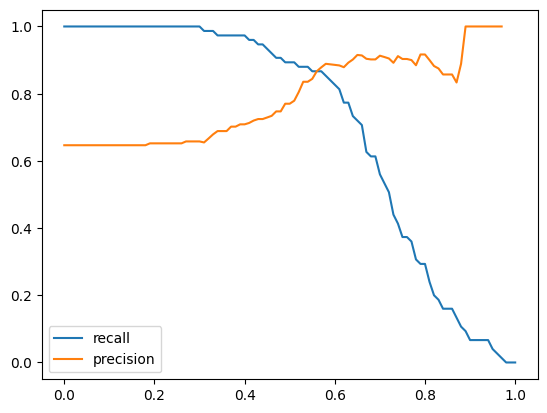

In [144]:
plt.plot(df_scores.threshols, df_scores['recall'], label='recall')
plt.plot(df_scores.threshols, df_scores['precision'], label='precision')
plt.legend()

In [145]:
df_scores['f1_score'] = 2*((df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall))

In [146]:
df_scores[df_scores.f1_score == df_scores.f1_score.max()]

,threshols,tp,fp,fn,tn,tpr,fpr,recall,precision,f1_score
57,0.57,65,9,10,32,0.866667,0.219512,0.866667,0.878378,0.872483


In [147]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [148]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):

    scores = []
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)
        
    for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
            
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.converted.values
        y_val = df_val.converted.values
        
        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
        print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0.591 +- 0.000
0.578 +- 0.014
0.565 +- 0.021
0.573 +- 0.022
0.556 +- 0.039
0.553 +- 0.036
0.543 +- 0.043
0.542 +- 0.040
0.538 +- 0.040
0.539 +- 0.038


0it [00:00, ?it/s]

0.841 +- 0.000
0.842 +- 0.001
0.847 +- 0.008
0.842 +- 0.011
0.852 +- 0.022
0.850 +- 0.020
0.864 +- 0.038
0.866 +- 0.035
0.869 +- 0.035
0.869 +- 0.033


0it [00:00, ?it/s]

0.810 +- 0.000
0.802 +- 0.007
0.802 +- 0.006
0.793 +- 0.017
0.810 +- 0.038
0.808 +- 0.035
0.824 +- 0.050
0.825 +- 0.046
0.829 +- 0.045
0.829 +- 0.043
